<a href="https://colab.research.google.com/github/AAA123404/Financial-big-data-analysis/blob/main/finallstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# !pip install yfinance pandas numpy matplotlib scikit-learn torch scipy

In [37]:
import pandas as pd
import numpy as np
import yfinance as yf
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 股票代碼與權重
tickers = ['2330.TW', '2317.TW', '2454.TW', '2881.TW', '2382.TW', '2308.TW', '2882.TW', '2412.TW']
weights = np.array([0.12, 0.03, 0.35, 0.16, 0.11, 0.01, 0.21, 0.01])

# 資料下載
start_date = '2019-01-01'
end_date = '2024-12-31'

def download_stock_data(tickers, start, end):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start, end=end)
        df['Return'] = df['Adj Close'].pct_change()
        df['MA5'] = df['Adj Close'].rolling(window=5).mean()
        df['MA20'] = df['Adj Close'].rolling(window=20).mean()
        df['RSI'] = calculate_rsi(df['Adj Close'])
        data[ticker] = df.dropna()
    return data

# RSI計算函數
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# 下載資料
stock_data = download_stock_data(tickers, start_date, end_date)

# 組合每日回報
portfolio_returns = pd.DataFrame(index=stock_data[tickers[0]].index)
portfolio_returns['Portfolio_Return'] = sum(stock_data[ticker]['Return'] * weight for ticker, weight in zip(tickers, weights))

# 計算7天移動平均回報率
portfolio_returns['7D_Return'] = portfolio_returns['Portfolio_Return'].rolling(window=7).mean()

# 計算7天波動率 (標準差)
portfolio_returns['7D_Volatility'] = portfolio_returns['Portfolio_Return'].rolling(window=7).std()

# 最大回撤
cumulative_return = (1 + portfolio_returns['Portfolio_Return']).cumprod()
rolling_max = cumulative_return.cummax()
portfolio_returns['Max_Drawdown'] = (cumulative_return - rolling_max) / rolling_max

# 計算夏普比率 (無風險利率設為0)
portfolio_returns['Sharpe_Ratio'] = portfolio_returns['7D_Return'] / portfolio_returns['7D_Volatility']
portfolio_returns['Sharpe_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# 計算在險價值 (VaR)，取5%分位數
portfolio_returns['VaR_5'] = portfolio_returns['Portfolio_Return'].rolling(window=7).quantile(0.05)

print(portfolio_returns.head(10))



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


            Portfolio_Return  7D_Return  7D_Volatility  Max_Drawdown  \
Date                                                                   
2019-01-29         -0.007343        NaN            NaN      0.000000   
2019-01-30         -0.006149        NaN            NaN     -0.006149   
2019-02-11          0.027013        NaN            NaN      0.000000   
2019-02-12          0.002218        NaN            NaN      0.000000   
2019-02-13          0.003291        NaN            NaN      0.000000   
2019-02-14         -0.003570        NaN            NaN     -0.003570   
2019-02-15         -0.007958   0.001072       0.012283     -0.011501   
2019-02-18          0.004949   0.002828       0.011746     -0.006609   
2019-02-19         -0.003576   0.003195       0.011455     -0.010161   
2019-02-20          0.016524   0.001697       0.007979      0.000000   

            Sharpe_Ratio     VaR_5  
Date                                
2019-01-29           NaN       NaN  
2019-01-30           NaN

<ipython-input-37-ef237ff34503>:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  portfolio_returns['Sharpe_Ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [38]:
# 特徵合併
features = []
for ticker in tickers:
    df = stock_data[ticker]
    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA20', 'RSI']]
    df.columns = [f"{ticker}_{col}" for col in df.columns]
    features.append(df)

feature_df = pd.concat(features, axis=1).dropna()
feature_df['Portfolio_Return'] = portfolio_returns['Portfolio_Return']
feature_df['7D_Return'] = portfolio_returns['7D_Return']
feature_df['7D_Volatility'] = portfolio_returns['7D_Volatility']
feature_df['Max_Drawdown'] = portfolio_returns['Max_Drawdown']
feature_df['Sharpe_Ratio'] = portfolio_returns['Sharpe_Ratio']
feature_df['VaR_5'] = portfolio_returns['VaR_5']

# 缺失值處理
feature_df = feature_df.dropna()

In [39]:
# 資料標準化
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(feature_df)

# 訓練集與測試集切分
train_data, test_data = train_test_split(scaled_features, test_size=0.2, random_state=42, shuffle=False)


In [40]:
feature_df

,"2330.TW_('Open', '2330.TW')","2330.TW_('High', '2330.TW')","2330.TW_('Low', '2330.TW')","2330.TW_('Close', '2330.TW')","2330.TW_('Volume', '2330.TW')","2330.TW_('MA5', '')","2330.TW_('MA20', '')","2330.TW_('RSI', '')","2317.TW_('Open', '2317.TW')","2317.TW_('High', '2317.TW')",...,"2412.TW_('Volume', '2412.TW')","2412.TW_('MA5', '')","2412.TW_('MA20', '')","2412.TW_('RSI', '')",Portfolio_Return,7D_Return,7D_Volatility,Max_Drawdown,Sharpe_Ratio,VaR_5
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-15,229.0,229.0,226.5,227.0,22369799,195.948560,191.440536,58.666647,71.500000,71.500000,...,8260742,84.553369,84.871243,45.454498,-0.007958,0.001072,0.012283,-0.011501,0.087249,-0.007774
2019-02-18,229.0,230.5,228.5,230.0,16978916,196.292029,192.041607,64.935035,70.800003,71.699997,...,8435027,84.553369,84.851376,45.454498,0.004949,0.002828,0.011746,-0.006609,0.240720,-0.007416
2019-02-19,230.0,230.5,229.0,229.0,16577023,196.120300,192.406544,60.810821,71.400002,72.300003,...,5957214,84.394432,84.811642,45.454577,-0.003576,0.003195,0.011455,-0.010161,0.278922,-0.006644
2019-02-20,231.5,234.5,231.0,234.5,30479710,197.064825,193.093480,64.197496,72.599998,73.800003,...,9254102,84.473900,84.811642,40.000077,0.016524,0.001697,0.007979,0.000000,0.212646,-0.006644
2019-02-21,235.5,236.5,234.5,236.5,33764489,198.696301,193.758949,69.999991,73.599998,73.800003,...,7410452,84.553368,84.791774,44.444397,0.005703,0.002195,0.008125,0.000000,0.270122,-0.006644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,1095.0,1095.0,1080.0,1080.0,26461906,1070.000000,1053.851721,53.296634,187.500000,187.500000,...,7022572,123.700000,123.700000,42.857143,-0.000033,-0.000222,0.011532,-0.001945,-0.019210,-0.011124
2024-12-25,1090.0,1090.0,1080.0,1085.0,15481622,1070.000000,1058.293109,53.300821,186.500000,188.000000,...,2168618,123.700000,123.725000,50.000000,0.001178,0.000905,0.011173,-0.000769,0.080999,-0.011124
2024-12-26,1085.0,1090.0,1085.0,1085.0,14374900,1073.000000,1062.485452,55.905547,187.500000,189.000000,...,2068776,123.800000,123.750000,46.153846,0.002047,0.000838,0.011163,0.000000,0.075111,-0.011124


In [41]:
class PortfolioDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.sequence_length]
        target_return = self.data[idx + self.sequence_length, -5]  # 7D_Return
        target_volatility = self.data[idx + self.sequence_length, -4]  # 7D_Volatility
        return torch.tensor(seq, dtype=torch.float32), torch.tensor([target_return, target_volatility], dtype=torch.float32)

# 建立 Dataset 和 DataLoader
sequence_length = 30
train_dataset = PortfolioDataset(train_data, sequence_length)
test_dataset = PortfolioDataset(test_data, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [42]:
import torch.nn as nn

class LSTMPortfolioPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPortfolioPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# 初始化模型
input_size = feature_df.shape[1]
hidden_size = 64
num_layers = 2
output_size = 2  # 預測回報率和波動率

model = LSTMPortfolioPredictor(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [43]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for seq, target in train_loader:
        optimizer.zero_grad()
        output = model(seq)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")


Epoch 1, Loss: 0.051217031251225204
Epoch 2, Loss: 0.013463126857661538
Epoch 3, Loss: 0.011288898893528514
Epoch 4, Loss: 0.009795052309830984
Epoch 5, Loss: 0.009089146430293718
Epoch 6, Loss: 0.008145161205902696
Epoch 7, Loss: 0.007142549613490701
Epoch 8, Loss: 0.006418913253583014
Epoch 9, Loss: 0.005867614488427837
Epoch 10, Loss: 0.005424438781725864
Epoch 11, Loss: 0.004935631851872636
Epoch 12, Loss: 0.004651363240554929
Epoch 13, Loss: 0.004346821586497956
Epoch 14, Loss: 0.0043476227955478765
Epoch 15, Loss: 0.0039901306154206395
Epoch 16, Loss: 0.0038249099420176614
Epoch 17, Loss: 0.003504726906410522
Epoch 18, Loss: 0.0032045243877089685
Epoch 19, Loss: 0.0031671467780446014
Epoch 20, Loss: 0.003359762175629536
Epoch 21, Loss: 0.0029584408815329275
Epoch 22, Loss: 0.0029527139332559374
Epoch 23, Loss: 0.0027979419553755885
Epoch 24, Loss: 0.0027135368695275653
Epoch 25, Loss: 0.0027195309715655944
Epoch 26, Loss: 0.0027250281742049586
Epoch 27, Loss: 0.002674478591264536

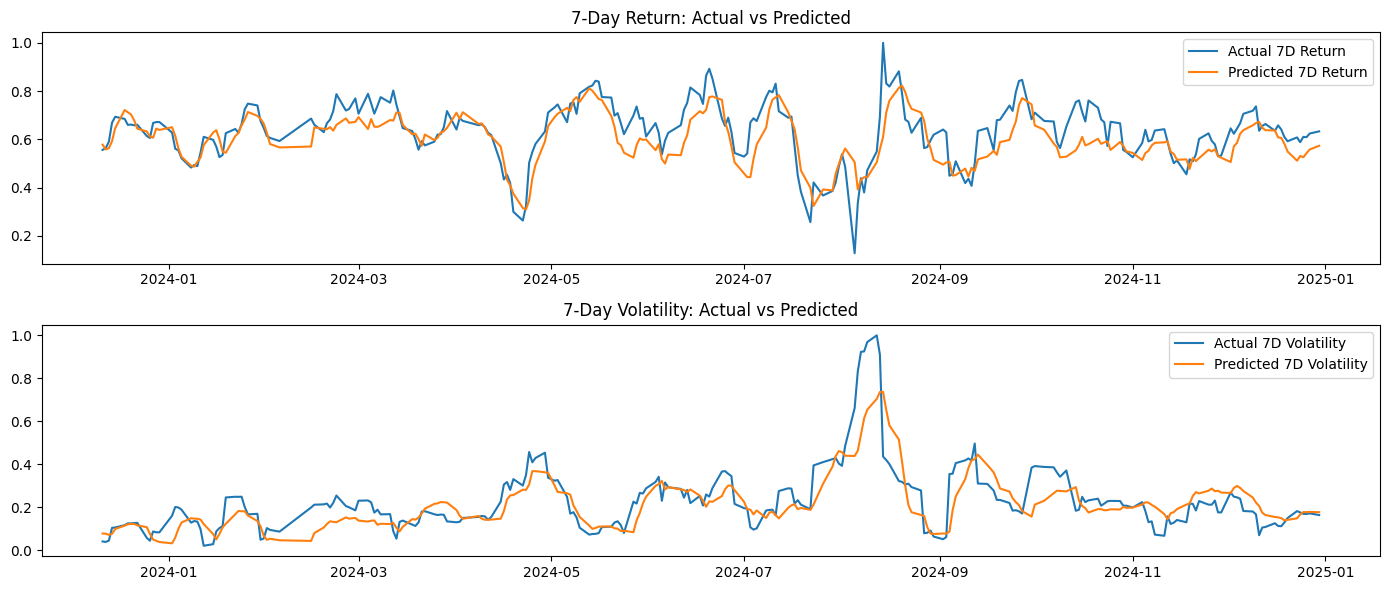

In [44]:
model.eval()
predictions, actuals = [], []

# 禁用梯度計算，進行模型預測
with torch.no_grad():
    for seq, target in test_loader:
        output = model(seq)
        predictions.append(output.numpy())  # 預測值
        actuals.append(target.numpy())  # 實際值

# 將預測與實際值轉換為 numpy array
predictions = np.vstack(predictions)
actuals = np.vstack(actuals)
dates = portfolio_returns.index[-len(predictions):]
# 視覺化
import matplotlib.pyplot as plt

# 繪製7天回報率比較圖
plt.figure(figsize=(14, 6))
plt.subplot(2, 1, 1)
plt.plot(dates,actuals[:, 0], label='Actual 7D Return')
plt.plot(dates,predictions[:, 0], label='Predicted 7D Return')
plt.title('7-Day Return: Actual vs Predicted')
plt.legend()

# 繪製7天波動率比較圖
plt.subplot(2, 1, 2)
plt.plot(dates,actuals[:, 1], label='Actual 7D Volatility')
plt.plot(dates,predictions[:, 1], label='Predicted 7D Volatility')
plt.title('7-Day Volatility: Actual vs Predicted')
plt.legend()

plt.tight_layout()
plt.show()



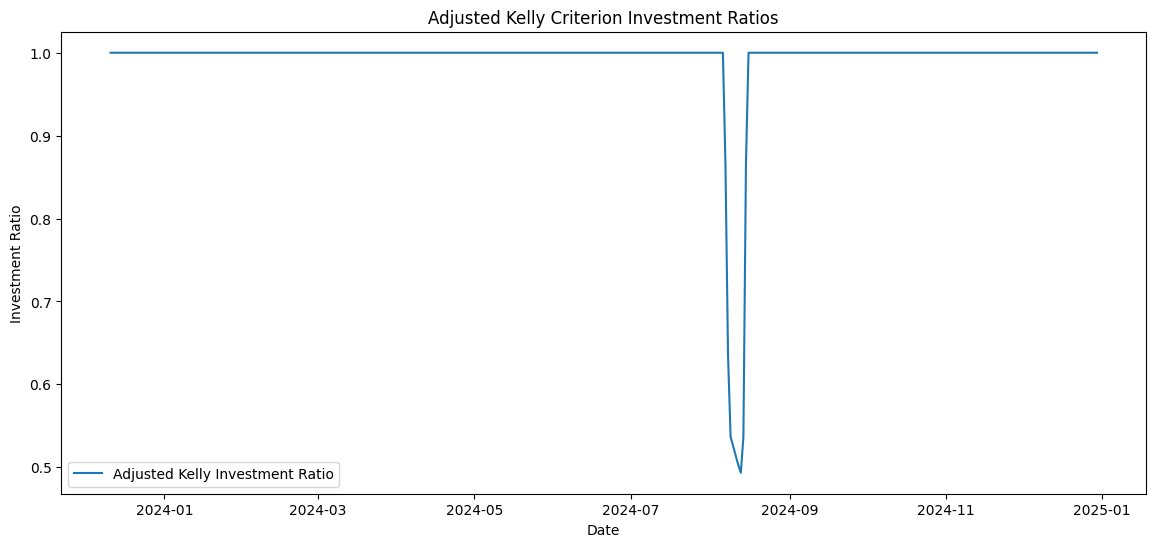

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# 預測結果
predicted_return = predictions[:, 0]  # 預測7天回報率
predicted_volatility = predictions[:, 1]  # 預測7天波動率

# 調整凱利公式以應對預測值平滑的問題
def kelly_criterion(expected_return, expected_volatility, risk_free_rate=0.0, epsilon=1e-6):
    """
    根據凱利公式計算投資比例，加入最小波動率閾值以避免計算異常。
    :param expected_return: 預測的回報率
    :param expected_volatility: 預測的波動率
    :param risk_free_rate: 無風險利率 (默認為0)
    :param epsilon: 最小波動率閾值
    :return: 投資比例
    """
    expected_volatility = max(expected_volatility, epsilon)  # 避免波動率為0
    # 置信調整，若預測波動率低於某個閾值，降低投資比例
    confidence_adjustment = np.exp(-expected_volatility)
    kelly_fraction = (expected_return - risk_free_rate) / (expected_volatility ** 2) * confidence_adjustment
    return np.clip(kelly_fraction, 0, 1)  # 限制在0到1之間

# 重新計算凱利比例
kelly_ratios = [kelly_criterion(r, v) for r, v in zip(predicted_return, predicted_volatility)]
kelly_ratios = np.array(kelly_ratios)
dates = portfolio_returns.index[-len(kelly_ratios):]
# 視覺化投資比例
plt.figure(figsize=(14, 6))
plt.plot(dates,kelly_ratios, label='Adjusted Kelly Investment Ratio')
plt.title('Adjusted Kelly Criterion Investment Ratios')
plt.xlabel('Date')
plt.ylabel('Investment Ratio')
plt.legend()
plt.show()


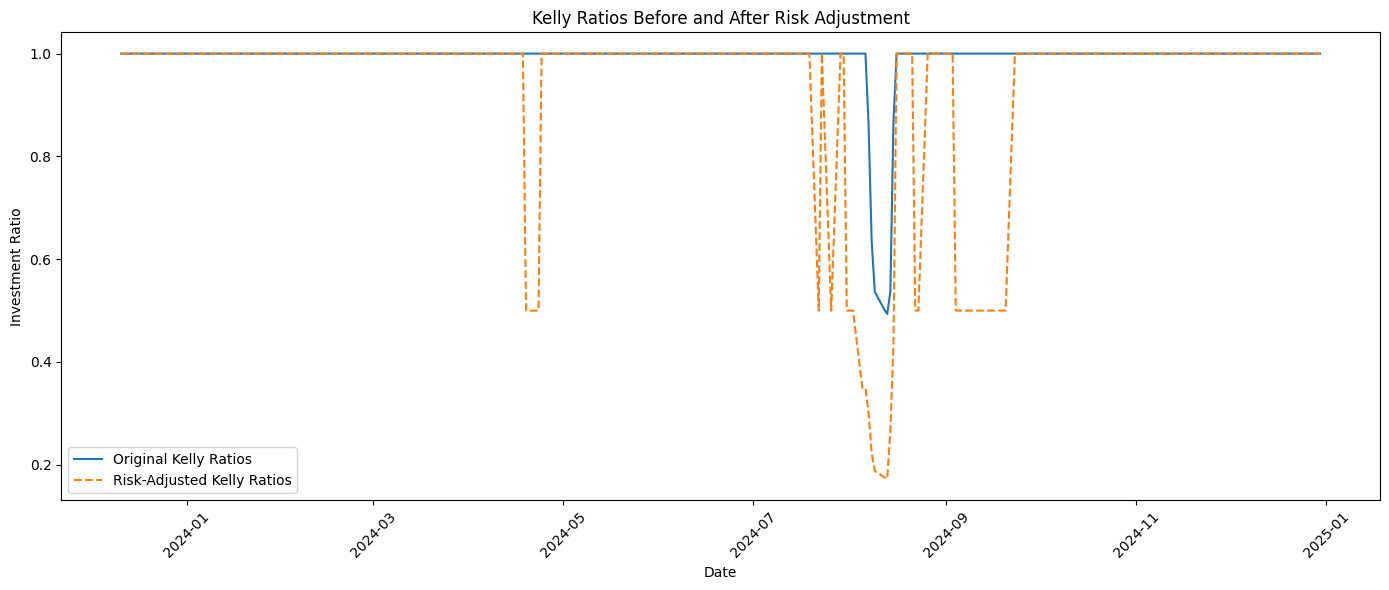

In [46]:
# 風險調整函數
def risk_adjustment(kelly_ratio, max_drawdown, var, max_drawdown_threshold=-0.1, var_threshold=-0.05):
    if max_drawdown < max_drawdown_threshold:
        kelly_ratio *= 0.5  # 回撤過大，減少投資比例
    if var < var_threshold:
        kelly_ratio *= 0.7  # VaR超出閾值，減少投資比例
    return kelly_ratio

# 最大回撤和VaR
max_drawdown = portfolio_returns['Max_Drawdown'].values[-len(kelly_ratios):]
var_5 = portfolio_returns['VaR_5'].values[-len(kelly_ratios):]

# 調整凱利比例
adjusted_kelly_ratios = [
    risk_adjustment(k, md, v) for k, md, v in zip(kelly_ratios, max_drawdown, var_5)
]

# 視覺化風險調整後的凱利比例 (使用日期)
plt.figure(figsize=(14, 6))
plt.plot(dates, kelly_ratios, label='Original Kelly Ratios')
plt.plot(dates, adjusted_kelly_ratios, label='Risk-Adjusted Kelly Ratios', linestyle='--')
plt.title('Kelly Ratios Before and After Risk Adjustment')
plt.xlabel('Date')
plt.ylabel('Investment Ratio')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



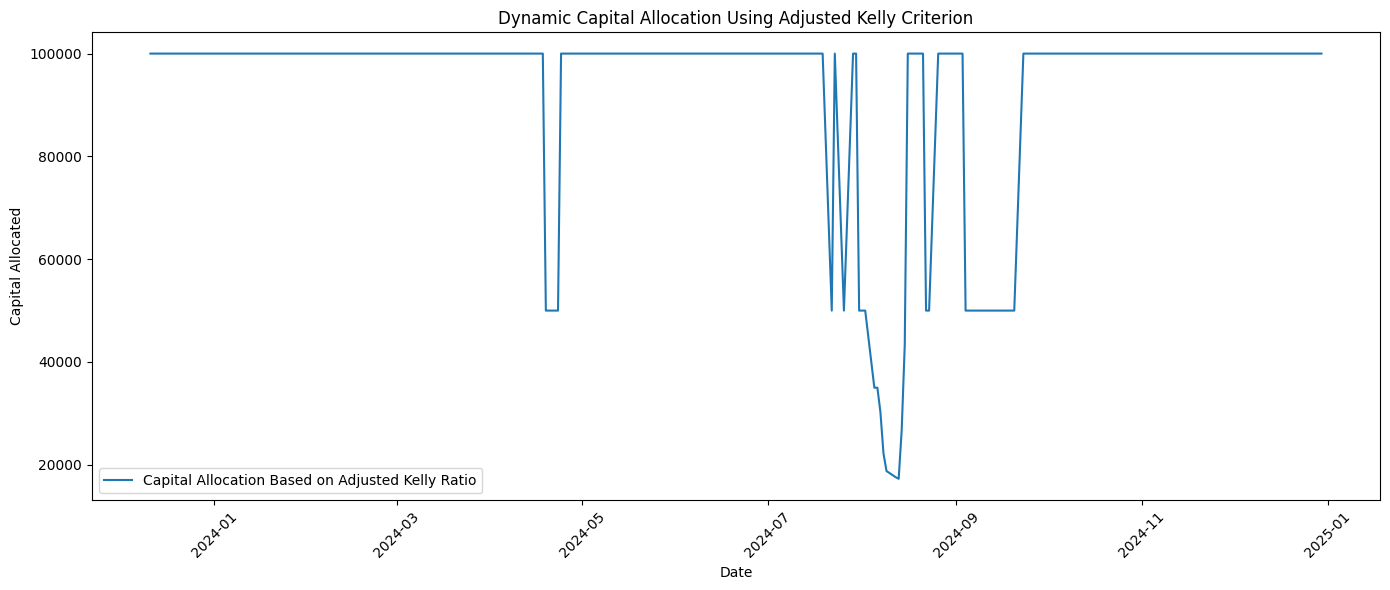

In [47]:
# 假設初始資金
initial_capital = 100000  # 初始資金 10萬

# 根據風險調整後的比例分配資金
capital_allocation = initial_capital * np.array(adjusted_kelly_ratios)

# 視覺化資金配置 (使用日期)
plt.figure(figsize=(14, 6))
plt.plot(dates, capital_allocation, label='Capital Allocation Based on Adjusted Kelly Ratio')
plt.title('Dynamic Capital Allocation Using Adjusted Kelly Criterion')
plt.xlabel('Date')
plt.ylabel('Capital Allocated')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
